## Bivariate Comparisons

This lab will describe how to make appropriate bivariate comparisons between variables measured at different levels of measurement. Remember, the main idea is to compare what happens to the outcome variable (either the distribution of its units across its values or some other relevant statistic) as the values of the predictor variable vary. 

For this lab, we will use the 2020 American National Election Study. The unit of analysis is the survey respondent, and the level of analysis is the individual. Let's install our necessary packages, along with the `devtools` package that will let us access the `anesr` set of functions to grab the data.

In [13]:
# Install the required packages if not already installed 

 #install.packages('pacman')

# we'll use devtools to install anesr, haven to load a stata dataset,
#   and knitr for table formatting.
pacman::p_load(tidyverse, devtools, haven, knitr, modelsummary)


# user-generated package to load American National Election Study survey data
# install_github("jamesmartherus/anesr") 

library(anesr)

Now we can load our data using the `data()` function. Because we loaded the `anesr` package, the ANES datasets can be read just like they're sitting in our working directory. 

In [2]:
# This is the 2020 election survey of the standard ANES time series survey. 
data(timeseries_2020)

Sometimes it is helpful to download a file, save it to your computer, and use it in your R script. You can download a file using `download.file` (clever naming, huh?). The code below saves a url and then uses `download.file` to get the .R file stored at that url and saves it with a different name into your working directory. Then, the code runs the R script.

In [8]:
# save the url for easy access. The paste0() function lets you combine
# strings together. paste with a 0 at the end will combine
# without any separator character between the strings of text

myurl = paste0("https://raw.githubusercontent.com/bowendc/510_labs/main/","anes20_recodes.R")

download.file(url = myurl, "anes20recodes.R" ) # anes20recodes.R is the name we're giving to the file 

source("anes20recodes.R") # runs the .R script recoding ANES variables

# one more recode: 

anes20 <- anes20 |> mutate(welfare_ord = ordered(welfare, labels = welfare_lbl), #
                           sex_fct = factor(sex, labels = sex_lbl))

### Crosstabs

In my opinion, crosstabs in R are more difficult than they need to be. Perhaps because of the difficulty of creating crosstabs in base R, there many packages offering additional functionality. I haven't found any that I really love. Because of this, we will create crosstabs several different ways here. 

First, let's see what is available in base R. 

In [9]:
# table will display a one-, two-, or even three-way frequency distribution (just the frequencies, not percentages).
# outcome goes first, predictor second
table(anes20$welfare_ord, anes20$sex_fct)

# wrap in prop.table( , 2) to get column proportions
prop.table(table(anes20$welfare_ord, anes20$sex_fct), 2)

# store for later use:
ct1 <- table(anes20$welfare_ord, anes20$sex_fct)

# call back up to create rounded percentages using round() function
round(prop.table(ct1, 2), digits = 3) * 100


                   
                     Men Women
  Increase a lot     538   742
  Increase a little  466   613
  Kept the same     1540  1952
  Decrease a little  504   501
  Decrease a lot     690   608

                   
                          Men     Women
  Increase a lot    0.1439272 0.1680254
  Increase a little 0.1246656 0.1388134
  Kept the same     0.4119850 0.4420290
  Decrease a little 0.1348315 0.1134511
  Decrease a lot    0.1845907 0.1376812

                   
                     Men Women
  Increase a lot    14.4  16.8
  Increase a little 12.5  13.9
  Kept the same     41.2  44.2
  Decrease a little 13.5  11.3
  Decrease a lot    18.5  13.8

This isn't bad, but we could also combine the table with the `kable()` function to add a caption and automate the rounding. If we were writing an interactive document using `knitr` or creating a table for a website with html, then the `kable()` function has some nice additional features as well. 

In [10]:
# Kable is from the knitr package and can be used to 
# add tables directly into written reports in pdf or html format 
# for print or web publishing

 kable(prop.table(ct1, 2)*100, align = "lccc", 
      format = "simple", 
      digits = 2, 
      caption = "Opinions about welfare spending by sex of respondent, 2020 ANES")



Table: Opinions about welfare spending by sex of respondent, 2020 ANES

                    Men      Women 
------------------  ------  -------
Increase a lot      14.39    16.80 
Increase a little   12.47    13.88 
Kept the same       41.20    44.20 
Decrease a little   13.48    11.35 
Decrease a lot      18.46    13.77 

Now let's use `datasummary_crosstab` to accomplish something similar.

In [ ]:
datasummary_crosstab(welfare_ord ~ sex_fct,
               data = anes20,
               statistic = 1 ~ 1 + Percent("col"))

# we can export to a csv file using the output argument

datasummary_crosstab(welfare_ord ~ sex_fct,
               data = anes20,
               statistic = 1 ~ 1 + Percent("col"),
               output = "lab4.ct2.csv")



+-------------------+-------+-------+-------+-------+
| welfare_ord       |       | Men   | Women | All   |
+===================+=======+=======+=======+=======+
| Increase a lot    | % col | 14.3  | 16.7  | 15.6  |
+-------------------+-------+-------+-------+-------+
| Increase a little | % col | 12.4  | 13.8  | 13.2  |
+-------------------+-------+-------+-------+-------+
| Kept the same     | % col | 40.9  | 43.9  | 42.5  |
+-------------------+-------+-------+-------+-------+
| Decrease a little | % col | 13.4  | 11.3  | 12.2  |
+-------------------+-------+-------+-------+-------+
| Decrease a lot    | % col | 18.3  | 13.7  | 15.8  |
+-------------------+-------+-------+-------+-------+
| All               | % col | 100.0 | 100.0 | 100.0 |
+-------------------+-------+-------+-------+-------+ 

### Mean comparisons 

Mean comparisons (or other some other statistic), can be created using `tidyverse` functions. Let's examine the thermometer ratings of the major political parties in the U.S. by gender.  

In [28]:
mc <- anes20 |> filter(!is.na(sex_fct)) |> 
                group_by(sex_fct) |> 
                summarize(Democratic = mean(dem_therm, na.rm = TRUE),
                          Republican = mean(rep_therm, na.rm = TRUE))
mc

mc |> 
  kable(align="lcc", 
        col.names = c("", "Democratic", "Republican"), 
        digits = 2, 
        format = "simple", 
        caption = "Mean thermometer ratings of political parties by sex of respondent, 2020 ANES") 

sex_fct,Democratic,Republican
<fct>,<dbl>,<dbl>
Men,41.03037,44.67367
Women,48.99954,43.03865




Table: Mean thermometer ratings of political parties by sex of respondent, 2020 ANES

         Democratic    Republican 
------  ------------  ------------
Men        41.03         44.67    
Women      49.00         43.04    

## Scatterplots and trend lines

**ggplot2** can be used to create scatterplots. By adding additional layers to the plot, we can overlay other graph types (like loess plots, lines of best fit, and more).

Warning message:
"Removed 1250 rows containing missing values (`geom_point()`)."


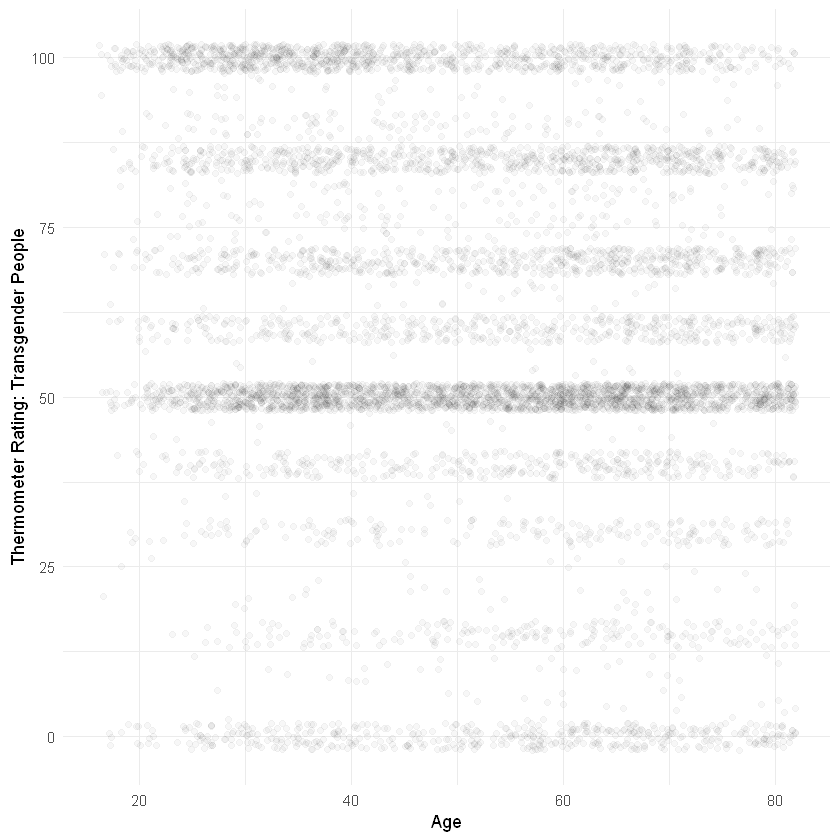

In [29]:
# assign graph to `plot` for easy access later 
plot <- ggplot(data = anes20, mapping = aes(x = age, y = trans_therm)) + 
            geom_jitter(size = 2, 
                        width= 2, 
                        height = 2, 
                        fill = "black", 
                        alpha = .03, 
                        stroke = 0 ) +
            labs(y = "Thermometer Rating: Transgender People",
                x = "Age") +
            theme_minimal()

plot

Now, let's add a loess line using `geom_smooth()`.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1250 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 1250 rows containing missing values (`geom_point()`)."


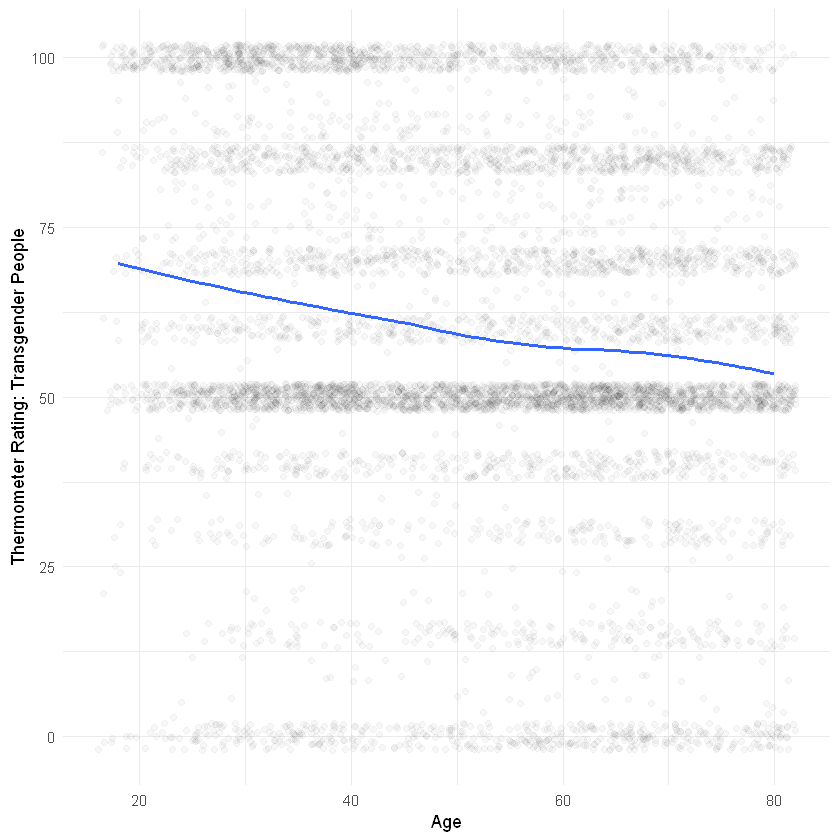

In [30]:
plot + geom_smooth(method = "loess", se = FALSE)

And a line of best fit!

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1250 rows containing non-finite values (`stat_smooth()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1250 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 1250 rows containing missing values (`geom_point()`)."


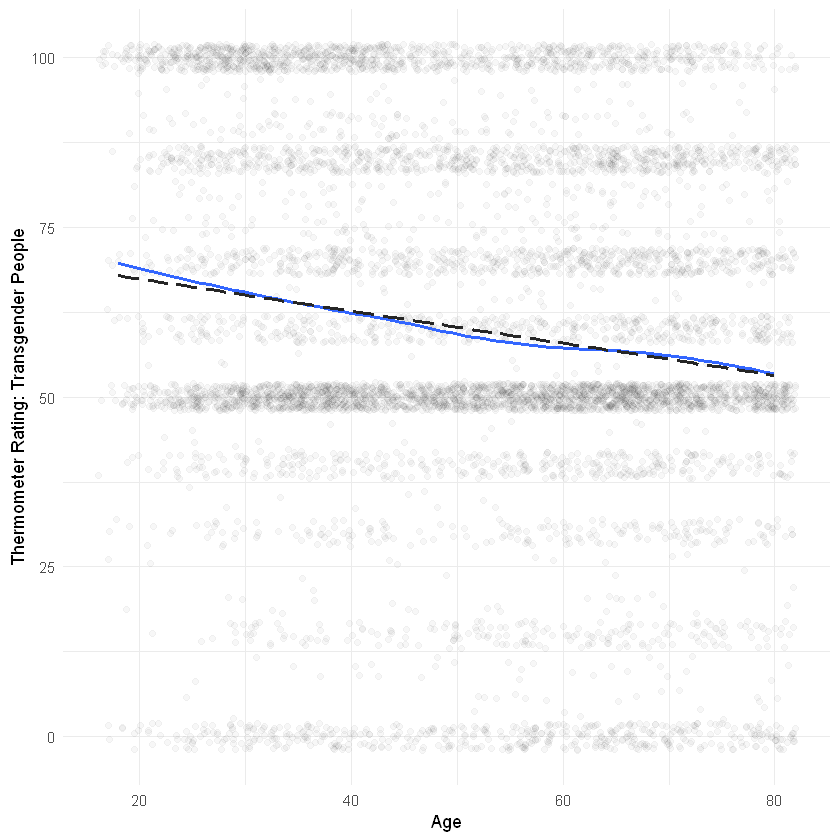

In [31]:
plot2 <- plot + geom_smooth(method = "loess", se = FALSE) +
                geom_smooth(method = "lm", se = FALSE,color = "grey15", linetype="longdash", linewidth = 1) 
plot2

Good! Now let's try recreating this graph accounting for party identification of the respondent using `facet_grid`.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1250 rows containing non-finite values (`stat_smooth()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1250 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 1250 rows containing missing values (`geom_point()`)."


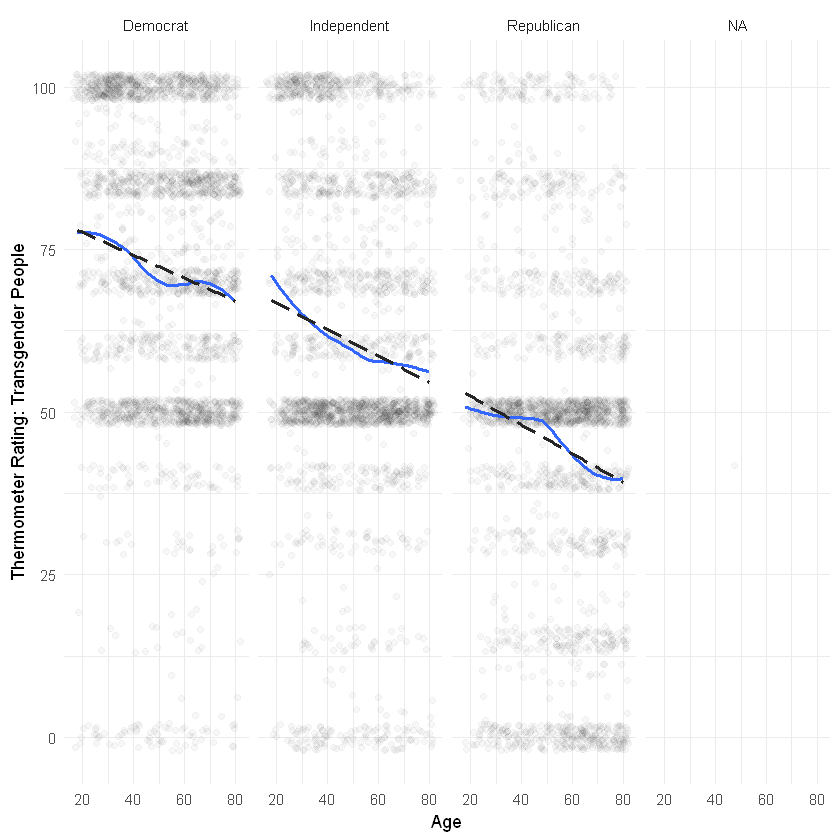

In [32]:
plot2 + facet_grid(~pid3)

Hmm. It looks like we have some missing values on the `pid3` variable. The respondents coded `NA` refused to answer the party identification question. Let's recreate our ggplot, this time using the `filter()` function in the `data` argument to filter out missing data on `pid3`.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1250 rows containing non-finite values (`stat_smooth()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1250 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 1250 rows containing missing values (`geom_point()`)."


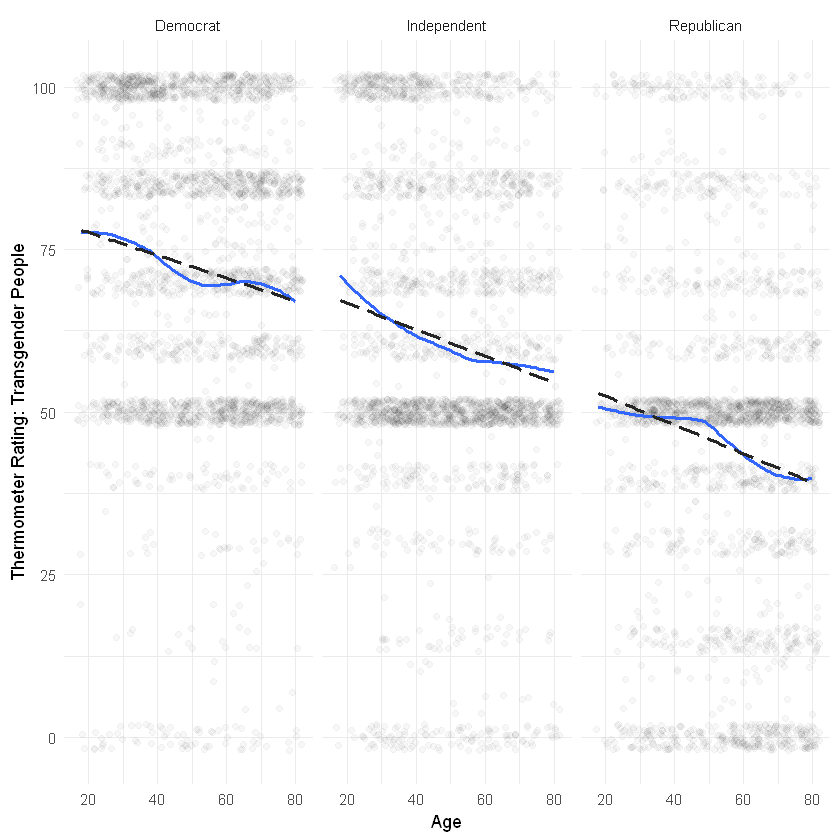

In [37]:
# is.na() function will identify whether the object is coded as missing data
# we can use it to flag observations with missing values on a specific variable
# ! means "does not" or "is not"
# so !is.na(pid3) means "is not coded NA on variable pid3"

plot3 <- ggplot(data = anes20 |> filter(!is.na(pid3)), mapping = aes(x = age, y = trans_therm)) + 
            geom_jitter(size = 2, 
                        width= 2, 
                        height = 2, 
                        fill = "black", 
                        alpha = .03, 
                        stroke = 0 ) +
            geom_smooth(method = "loess", se = FALSE) +
            geom_smooth(method = "lm", se = FALSE,color = "grey15", linetype="longdash", linewidth = 1) +
            labs(y = "Thermometer Rating: Transgender People",
                x = "Age") +
            theme_minimal() + facet_grid(~pid3)
plot3